复现一下小土堆的完整模型训练，使用pytorch训练需要这几步：
(1)准备数据建立dataloader 关键库：torch.torchvision.dataset, Dataloader
(2)建立模型。关键库torch.nn.Module 卷积核 线性核 激活函数
(3)进行训练。关键点 loss_fn(criterion), losses = [], optimizer, loss,每次backward()之前要注意梯度清零 
(4)进行测试。无梯度的时候进行forward,计算平均精度 保存模型
(5)推理测试。

In [1]:
import torch 
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
device = torch.device('cuda')

#准备数据
def prepare_data(path):
    train = torchvision.datasets.CIFAR10(path,train=True, transform=torchvision.transforms.ToTensor(), download=True)
    test = torchvision.datasets.CIFAR10(path,train=False, transform=torchvision.transforms.ToTensor(), download=True)
    print(f"train_length: {len(train)}")
    print(f"test_length: {len(test)}")
    train_dl = DataLoader(train, batch_size=32, shuffle=True)
    test_dl = DataLoader(test, batch_size=64, shuffle=False)
    return train_dl, test_dl

class Mymodel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model1 = nn.Sequential(
            nn.Conv2d(3,32,5,1,2), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32,32,5,1,2), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32,64,5,1,2), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64*4*4,64),
            nn.Linear(64,10)
        )
    
    def forward(self,x):
        x = self.model1(x)
        return x


Files already downloaded and verified
Files already downloaded and verified
train_length: 50000
test_length: 10000
Epoch:1/51, loss: 1.6800
Epoch:2/51, loss: 1.2421
Epoch:3/51, loss: 1.0791
Epoch:4/51, loss: 0.9568
Epoch:5/51, loss: 0.8687
Epoch:6/51, loss: 0.8180
Epoch:7/51, loss: 0.7593
Epoch:8/51, loss: 0.7241
Epoch:9/51, loss: 0.6931
Epoch:10/51, loss: 0.6656
Epoch:11/51, loss: 0.6379
Epoch:12/51, loss: 0.6228
Epoch:13/51, loss: 0.6074
Epoch:14/51, loss: 0.5938
Epoch:15/51, loss: 0.5859
Epoch:16/51, loss: 0.5742
Epoch:17/51, loss: 0.5735
Epoch:18/51, loss: 0.5526
Epoch:19/51, loss: 0.5619
Epoch:20/51, loss: 0.5487
Epoch:21/51, loss: 0.5566
Epoch:22/51, loss: 0.5404
Epoch:23/51, loss: 0.5414
Epoch:24/51, loss: 0.5473
Epoch:25/51, loss: 0.5433
Epoch:26/51, loss: 0.5224
Epoch:27/51, loss: 0.5260
Epoch:28/51, loss: 0.5377
Epoch:29/51, loss: 0.5179
Epoch:30/51, loss: 0.5250
Epoch:31/51, loss: 0.5394
Epoch:32/51, loss: 0.5260
Epoch:33/51, loss: 0.5329
Epoch:34/51, loss: 0.5165
Epoch:35/5

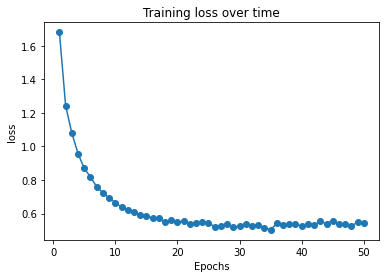

Accuary: 0.6428999900817871


In [ ]:
from matplotlib import pyplot as plt
def train_model(train_dl, model,epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(),lr=0.01,momentum=0.9)
    losses = []
    model.to(device)
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for data in train_dl:
            imgs, targets = data
            imgs = imgs.to(device)
            targets = targets.to(device)
            yhat = model(imgs)
            loss = criterion(yhat,targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(train_dl)
        losses.append(avg_loss)
        print(f"Epoch:{epoch + 1}/{epochs}, loss: {avg_loss:.4f}")
    plt.plot(range(1, epochs+1), losses, marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('loss')
    plt.title('Training loss over time')
    plt.show()
    
def evaluate_model(test_dl, model):
    model.to(device)
    model.eval()
    total_acc = 0.0
    with torch.no_grad():
        for data in test_dl:
            imgs, targets = data
            imgs = imgs.to(device)
            targets = targets.to(device)
            yhat = model(imgs)
            acc = (yhat.argmax(1) == targets).sum()
            total_acc += acc
    total_acc = total_acc / len(test_dl.dataset)
    return total_acc

if __name__ == '__main__':
    path = './dataset'
    train_dl,test_dl = prepare_data(path)
    mymodel = Mymodel()
    train_model(train_dl, mymodel, 50)
    acc = evaluate_model(test_dl, mymodel)
    print(f"Accuary: {acc}")
    torch.save(mymodel.state_dict(),'mymodel_CIFAR10.pth')

In [11]:
#验证模型有效性：
from PIL import Image
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse','ship', 'truck']

image_path = './images/plane1.jpeg'
img = Image.open(image_path)
img = img.convert("RGB")
print(img)
device = torch.device('cuda')
transform = torchvision.transforms.Compose([torchvision.transforms.Resize((32, 32)),
                                            torchvision.transforms.ToTensor()])
img = transform(img)
print(img.shape)
model = Mymodel()
model.load_state_dict(torch.load('mymodel_CIFAR10.pth', map_location=device))
model.to(device)
model.eval()
img = torch.reshape(img,(1,3,32,32))
img = img.to(device)
with torch.no_grad():
    output = model(img)
print(f'识别结果为：{class_names[output.argmax(1).item()]}')


<PIL.Image.Image image mode=RGB size=474x295 at 0x2A5821E4780>
torch.Size([3, 32, 32])
识别结果为：airplane
